In [43]:
import numpy as np
import sklearn

import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import metrics
from sklearn_extra.cluster import KMedoids

In [44]:
# Importamos los datos

X=np.load("./datos_mfcc_pca99_X.npy")
y=np.load("./datos_mfcc_pca99_y.npy")

In [87]:
#Reducimos el conjunto de entrenamiento al 50% usando un método no supervisado. En este caso, un C-means con el que pretendemos
# quedarnos con los centros de los clusters que aparezcan, que serán los puntos más representativos.

c = 6             # número de clases
nc = 120          # muestras por clase
n= 720           # número de muestras totales

X_reduc=[]
y_reduc=np.int16(np.kron(np.arange(c),np.ones(nc//2)))

for i in range(0,n,nc):
    k_medoids=KMedoids(n_clusters=nc//2)
    k_medoids.fit(X[i:(i+nc)])
    centros=k_medoids.cluster_centers_
    X_reduc.append(centros)

In [88]:
print(X_reduc[0].shape)
# Reshapeamos las dimensiones de X_reduc para tenerlo todo en una matriz dónde cada fila será una muestra y cada columna una 
# característica. La matriz estará ordenada por clases. 
# Para reshapear, antes habrá que convertir a array.


X_reduc=np.array(X_reduc).reshape((360,464))
print(X_reduc.shape)

(60, 464)
(360, 464)


In [47]:
# Ahora ya podemos dividir nuestro conjunto reducido en entrenamiento y test, y probar algunos métodos Kernel.

Xtr, Xts, ytr, yts = train_test_split(X_reduc, y_reduc, test_size=0.3, shuffle=True, random_state=0)

In [48]:
# Aplicamos un clasificador de tipo árbol de decisión. De momento, con los parámetros por defecto.

clf_tree = DecisionTreeClassifier(random_state=0)
clf_tree.fit(Xtr,ytr)

score_tr = clf_tree.score(Xtr,ytr)
score_ts = clf_tree.score(Xts,yts)
preds_train=clf_tree.predict(Xtr)
preds_test = clf_tree.predict(Xts)

print('')
print('OA train %0.2f' % score_tr)
print('Kappa train %0.2f' % metrics.cohen_kappa_score(ytr,preds_train))
print('OA test %0.2f' % score_ts)
print('Kappa test %0.2f' % metrics.cohen_kappa_score(yts,preds_test))


OA train 1.00
Kappa train 1.00
OA test 0.40
Kappa test 0.27


In [49]:
clf_tree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 0,
 'splitter': 'best'}

Los resultados parecen sospechosos. Tenemos mucho acierto en entrenamiento y poco en test, esto es un claro caso de overfitting. Esto seguramente se deba a que hemos dejado que el árbol crezca hasta que todos sus nodos son hojas, es decir,  que expandimos hasta que todos los nodos lleguen al mínimo de puntos definidos por defecto (=2).

Para solucionarlo, haremos un barrido de varios árboles variando la profundidad máxima y después pintaremos la típica gráfica de acierto en entrenamiento y test para ver a partir de qué momento empezamos a tener sobreajuste.

In [50]:
# Fijamos el random_state para que siempre que entremos en el bucle hagamos el mismo árbol.

depth=np.arange(1,12)
score2_tr=[]
score2_ts=[]
preds2_train=[]
preds2_test=[]



for i in depth:
    clf2_tree=DecisionTreeClassifier(criterion="gini",splitter="best",max_depth=i,random_state=0)
    clf2_tree.fit(Xtr,ytr)
    
    score2_tr.append(clf2_tree.score(Xtr,ytr))
    score2_ts.append(clf2_tree.score(Xts,yts))
    preds2_train.append(clf2_tree.predict(Xtr))
    preds2_test.append(clf2_tree.predict(Xts))


Text(0, 0.5, 'Accuracy')

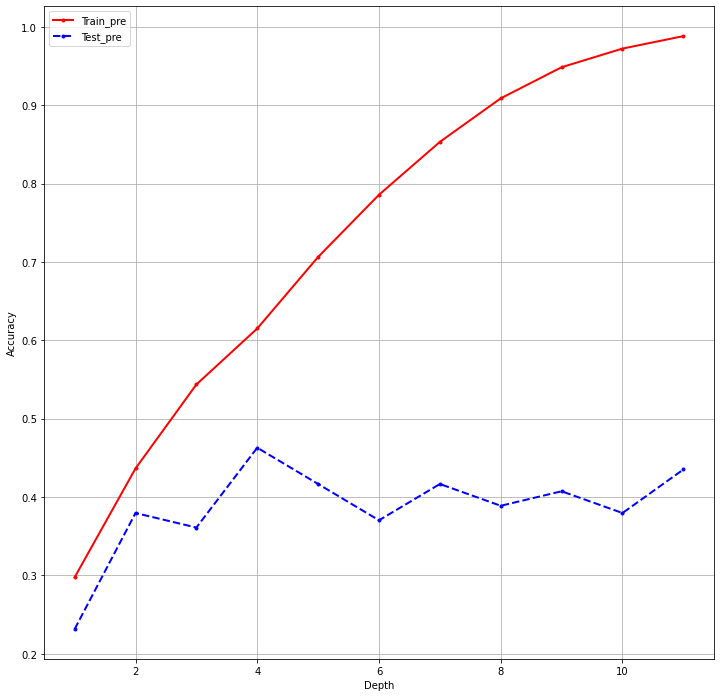

In [51]:
# Pintamos la evolución del acierto en entrenamiento y test, en función de la profundidad del árbol.

plt.figure(figsize=(12,12))
plt.plot(depth,score2_tr,".-r",label="Train_pre",linewidth=2)
plt.plot(depth,score2_ts,".--b",label="Test_pre",linewidth=2)
plt.legend()
plt.grid()
plt.xlabel("Depth")
plt.ylabel("Accuracy")

In [57]:
max(score2_ts)

0.46296296296296297

Obsevamos como con una profundidad de 4, tenemos el pico de acierto en test. A partir de ahí, el acierto baja para test y sigue subiendo para entrenamiento. Esto se conoce como sobre entrenamiento ("overfitting"), y vemos que si lo dejamos llegamos a obtener un acierto de 1 en entrenamiento, pero eso no nos interesa. 

Con los parámetros usados, deberíamos de quedarnos con el árbol de profundidad cuatro.

También podemos probar a cambiar el criterio de división. En lugar de usar la impureza de gini, podemos usar la entropía y ver si mejoran mis resultados.


In [53]:
# Fijamos el random_state para que siempre que entremos en el bucle hagamos el mismo árbol.

depth=np.arange(1,12)
score3_tr=[]
score3_ts=[]
preds3_train=[]
preds3_test=[]


for i in depth:
    clf3_tree=DecisionTreeClassifier(criterion="entropy",splitter="best",max_depth=i,random_state=0)
    clf3_tree.fit(Xtr,ytr)
    
    score3_tr.append(clf3_tree.score(Xtr,ytr))
    score3_ts.append(clf3_tree.score(Xts,yts))
    preds3_train.append(clf3_tree.predict(Xtr))
    preds3_test.append(clf3_tree.predict(Xts))


Text(0, 0.5, 'Accuracy')

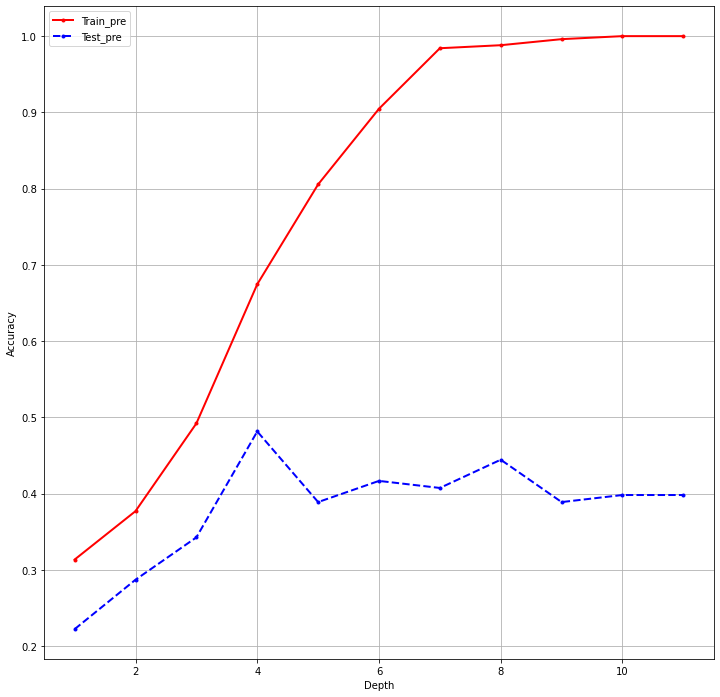

In [54]:
# Pintamos la evolución del acierto en entrenamiento y test, en función de la profundidad del árbol.

plt.figure(figsize=(12,12))
plt.plot(depth,score3_tr,".-r",label="Train_pre",linewidth=2)
plt.plot(depth,score3_ts,".--b",label="Test_pre",linewidth=2)
plt.legend()
plt.grid()
plt.xlabel("Depth")
plt.ylabel("Accuracy")

In [56]:
max(score3_ts)

0.48148148148148145

Con el criterio de división por la entropía, vemos que el máximo pico de acierto en test se alcanza con una profundidad de cuatro también,y además nos da un acierto mayor que el que obteníamos con el criterio de división por la impureza de Gini. 

Por tanto, nos quedamos con el nuevo clasificador (`clf3_tree`) que nos da mejores resultados.

Otra de las opciones que tenemos es aplicar algún método de poda para ver si mejoramos los resultados. En particular, usaremos el único método de poda que está implementado en `scikit-learn`.

In [62]:
# Para aplicar métodos de poda, lo que haremos será dejar crecer el árbol hasta el final y luego ir cortando hojas. 

clf4_tree=DecisionTreeClassifier(criterion="entropy",splitter="best",max_depth=12,random_state=0)
clf4_tree.fit(Xtr,ytr)

# Una vez creado y entrenado el árbol, calculamos los parámetros para hacer la poda.

path = clf4_tree.cost_complexity_pruning_path(Xtr, ytr)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Ahora hacemos un bucle para ir aplicando la poda de abajo-arriba del árbol. Lo vamos podando de menos a más, ya que el último
# valor de ccp_alphas sería el que nos poda el árbol entero dejando un solo nodo.

clfs = []    # bolsa de árboles en la que vamos guardando árboles con diferentes níveles de poda.

for ccp_alpha in ccp_alphas:
    tree_aux = DecisionTreeClassifier(criterion="entropy",splitter="best",random_state=0,ccp_alpha=ccp_alpha)
    tree_aux.fit(Xtr, ytr)
    clfs.append(tree_aux)
    
# Calculamos las métricas para cada uno de los árboles calculados para luego poder representarlas.

depth4 = [clf.tree_.max_depth for clf in clfs]
score4_tr = [clf.score(Xtr, ytr) for clf in clfs]
score4_ts = [clf.score(Xts, yts) for clf in clfs]

Text(0, 0.5, 'Accuracy')

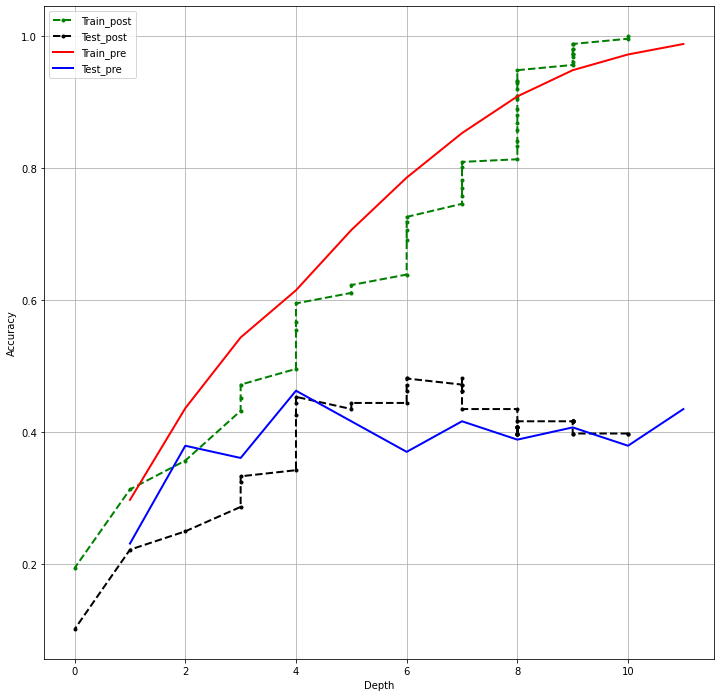

In [63]:
# Una vez hecha la poda a diferentes níveles, representamos los resultados de acierto en los árboles pre-poda y post-poda para
# ver si mejoramos.

#lo representamos todo
plt.figure(figsize=(12,12))
plt.plot(depth4,score4_tr,".--g",label="Train_post",linewidth=2)

plt.plot(depth4,score4_ts,".--k",label="Test_post",linewidth=2)

plt.plot(depth,score2_tr,"-r",label="Train_pre",linewidth=2)

plt.plot(depth,score2_ts,"-b",label="Test_pre",linewidth=2)
plt.legend()
plt.grid()
plt.xlabel("Depth")
plt.ylabel("Accuracy")

Observamos como al hacer la poda obtenemos mejores resultados para una profundidad de seis. Podría ser planteable quedarnos con dicho árbol. Lo hacemos.

In [64]:
score4_ts

[0.39814814814814814,
 0.39814814814814814,
 0.39814814814814814,
 0.39814814814814814,
 0.4166666666666667,
 0.4166666666666667,
 0.4166666666666667,
 0.4166666666666667,
 0.4166666666666667,
 0.4166666666666667,
 0.4166666666666667,
 0.4166666666666667,
 0.39814814814814814,
 0.39814814814814814,
 0.4074074074074074,
 0.4074074074074074,
 0.4074074074074074,
 0.4074074074074074,
 0.39814814814814814,
 0.4074074074074074,
 0.39814814814814814,
 0.39814814814814814,
 0.39814814814814814,
 0.4074074074074074,
 0.4351851851851852,
 0.4351851851851852,
 0.46296296296296297,
 0.4722222222222222,
 0.48148148148148145,
 0.46296296296296297,
 0.4722222222222222,
 0.48148148148148145,
 0.48148148148148145,
 0.4722222222222222,
 0.46296296296296297,
 0.4444444444444444,
 0.4444444444444444,
 0.4351851851851852,
 0.4537037037037037,
 0.4444444444444444,
 0.42592592592592593,
 0.3425925925925926,
 0.3333333333333333,
 0.32407407407407407,
 0.28703703703703703,
 0.25,
 0.2222222222222222,
 0.10185

Vemos que hay 3 árboles que nos dan el máximo de acierto en test pero con diferentes níveles de poda. Nos quedamos con el primero de ellos por ser el más sencillo.

In [65]:
print(max(score4_ts))
print(score4_ts.index(max(score4_ts)))

0.48148148148148145
28


In [66]:
indice=score4_ts.index(max(score4_ts))
clf_tree_final = clfs[indice]
print(clf_tree_final)

DecisionTreeClassifier(ccp_alpha=0.04930606488186063, criterion='entropy',
                       random_state=0)


In [67]:
clf_tree_final.get_params()

{'ccp_alpha': 0.04930606488186063,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 0,
 'splitter': 'best'}

In [68]:
# Mostramos el acierto en entrenamiento y en test del árbol final con el que nos hemos quedado.

print("OA train %0.2f" %clf_tree_final.score(Xtr, ytr))
print("OA test %0.2f" %clf_tree_final.score(Xts, yts))

OA train 0.77
OA test 0.48


Los resultados son un poco mediocres. Con los métodos Kernel obtenemos mejores resultados.

De hecho, nos damos cuenta de que tras hacer la poda, se nos queda el mismo acierto en test que teníamos sin hacer la poda y con el criterio de entropía. Por lo tanto, concluimos que no merece la pena hacer poda. 

Nos quedamos con el árbol de decisión sin poda (`clf3_tree`).

Finalemente, la función `DecisionTreeClassifier` trae implementado un método que nos permite ver la importancia de cada una de las características que estamos teniendo en cuenta a la hora de construir el árbol. 

Echar un vistazo a esa importancia nos puede permitir eliminar algunas características que tengan muy poca importancia. Al hacer esto es posible que los resultados mejoren.

In [75]:
importancias=clf3_tree.feature_importances_
print(importancias)

[0.19171138 0.14265591 0.02733636 0.01834072 0.         0.02838608
 0.         0.         0.01493376 0.         0.         0.02403657
 0.         0.01538056 0.         0.         0.         0.
 0.         0.         0.02268811 0.         0.         0.
 0.         0.01355474 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.02508542 0.03101649
 0.         0.         0.00555183 0.         0.         0.
 0.         0.02267041 0.         0.01614087 0.         0.
 0.         0.         0.         0.         0.019302   0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.00499116 0.         0.       

Hemos obtenido la importancia de cada característica, también conocida como importancia de Gini. 

Vemos que hay muchas características con una importancia de cero. Una opción podría ser eliminar dichas características y volver a realizar el árbol para ver si mejoramos resultados. La alta dimensionalidad puede ser un problema.

In [89]:
indices=np.where(importancias!=0)


In [90]:
X_reduc=X_reduc[:,indices]

In [92]:
print(X_reduc.shape)
X_reduc= X_reduc.reshape((360,44))
print(X_reduc.shape)

(360, 1, 44)
(360, 44)


In [94]:
# Ahora volvemos a dividir dividir nuestro conjunto reducido en entrenamiento y test, y probar algunos métodos Kernel.
# Fijamos el mismo random_state para que se construyan los mismos subconjuntos.

Xtr, Xts, ytr, yts = train_test_split(X_reduc, y_reduc, test_size=0.3, shuffle=True, random_state=0)

In [95]:
Xtr.shape

(252, 44)

Text(0, 0.5, 'Accuracy')

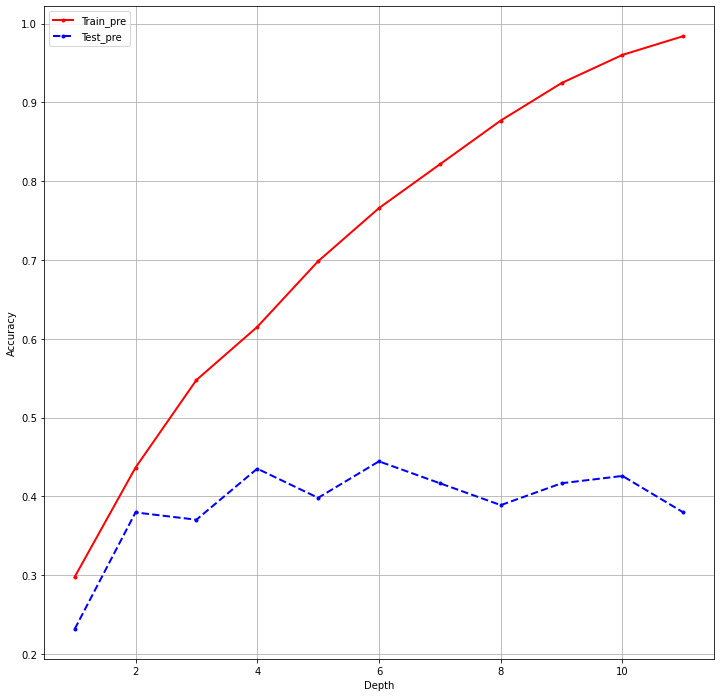

In [96]:
# Fijamos el random_state para que siempre que entremos en el bucle hagamos el mismo árbol.

depth=np.arange(1,12)
score2_tr=[]
score2_ts=[]
preds2_train=[]
preds2_test=[]



for i in depth:
    clf2_tree=DecisionTreeClassifier(criterion="gini",splitter="best",max_depth=i,random_state=0)
    clf2_tree.fit(Xtr,ytr)
    
    score2_tr.append(clf2_tree.score(Xtr,ytr))
    score2_ts.append(clf2_tree.score(Xts,yts))
    preds2_train.append(clf2_tree.predict(Xtr))
    preds2_test.append(clf2_tree.predict(Xts))

    
# Pintamos la evolución del acierto en entrenamiento y test, en función de la profundidad del árbol.

plt.figure(figsize=(12,12))
plt.plot(depth,score2_tr,".-r",label="Train_pre",linewidth=2)
plt.plot(depth,score2_ts,".--b",label="Test_pre",linewidth=2)
plt.legend()
plt.grid()
plt.xlabel("Depth")
plt.ylabel("Accuracy")

Parece que empeoran un poco los resultados. 

Text(0, 0.5, 'Accuracy')

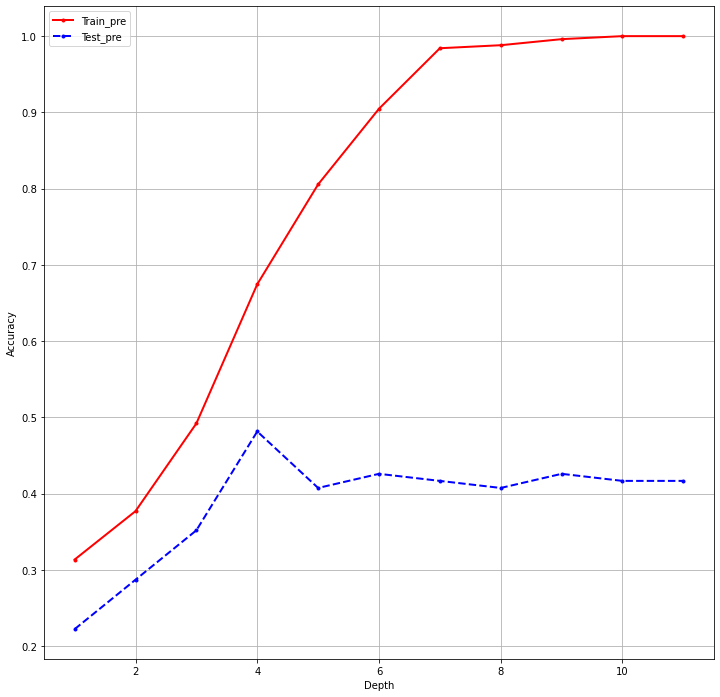

In [97]:
# Fijamos el random_state para que siempre que entremos en el bucle hagamos el mismo árbol.

depth=np.arange(1,12)
score3_tr=[]
score3_ts=[]
preds3_train=[]
preds3_test=[]


for i in depth:
    clf3_tree=DecisionTreeClassifier(criterion="entropy",splitter="best",max_depth=i,random_state=0)
    clf3_tree.fit(Xtr,ytr)
    
    score3_tr.append(clf3_tree.score(Xtr,ytr))
    score3_ts.append(clf3_tree.score(Xts,yts))
    preds3_train.append(clf3_tree.predict(Xtr))
    preds3_test.append(clf3_tree.predict(Xts))

    
# Pintamos la evolución del acierto en entrenamiento y test, en función de la profundidad del árbol.

plt.figure(figsize=(12,12))
plt.plot(depth,score3_tr,".-r",label="Train_pre",linewidth=2)
plt.plot(depth,score3_ts,".--b",label="Test_pre",linewidth=2)
plt.legend()
plt.grid()
plt.xlabel("Depth")
plt.ylabel("Accuracy")

In [98]:
max(score3_ts)

0.48148148148148145

Con el criterio de entropía sin embargo, parece que los resultados se mantienen pero con el hecho de que en este caso tenemos menos características. Esto ayudará a que el árbol sea más sencillo y entendible.

In [100]:
clf3_tree.feature_importances_

array([0.19171138, 0.14265591, 0.04291925, 0.01834072, 0.02838608,
       0.01493376, 0.02403657, 0.01538056, 0.03015499, 0.01355474,
       0.0325523 , 0.03101649, 0.00743568, 0.02267041, 0.01614087,
       0.02485383, 0.        , 0.02409736, 0.        , 0.        ,
       0.00499116, 0.02058096, 0.00615222, 0.02045349, 0.        ,
       0.03221505, 0.04054283, 0.00746688, 0.0184964 , 0.01681761,
       0.        , 0.01487136, 0.02807663, 0.02218665, 0.        ,
       0.        , 0.019302  , 0.01599926, 0.        , 0.        ,
       0.01802857, 0.00499116, 0.00847434, 0.01951253])